In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy import stats
import statsmodels.graphics.api as smg
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv(r"/Users/itt/.cache/kagglehub/datasets/mirichoi0218/insurance/versions/1/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
print(df.describe())
print(df.info())
print(df.isna().sum())
print(df.duplicated())
df = df.drop_duplicates()
df = df.dropna()

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: floa

/Users/itt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


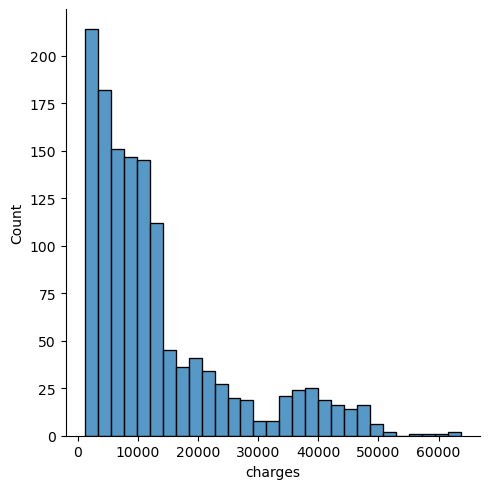

In [5]:
sns.displot(data = df["charges"])

/Users/itt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


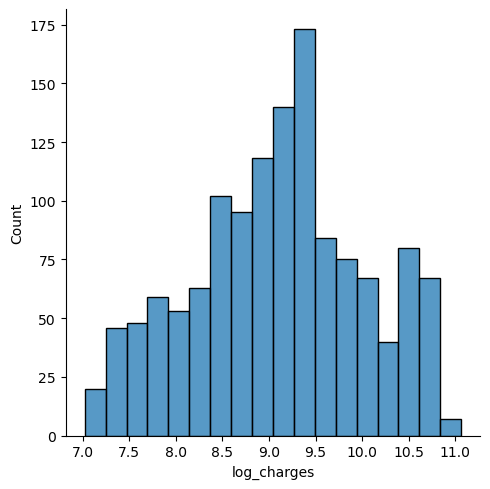

In [6]:
df['log_charges'] =  np.log(df['charges'])
sns.displot(data = df['log_charges'])

/var/folders/_f/1gthx_hs1cb8q7jhfs1bj0jr0000gn/T/ipykernel_3077/3266951532.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

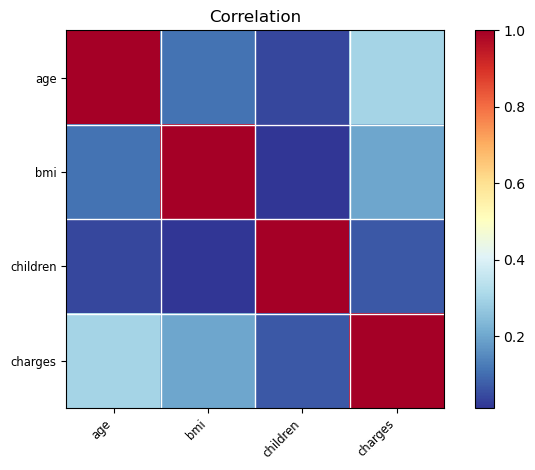

In [7]:
num_cols = ['age', 'bmi', 'children', 'charges']
corr = np.corrcoef(df[num_cols].values, rowvar = False)
fig = plt.figure(figsize=(10, 8))
smg.plot_corr(corr, xnames=num_cols)
plt.title('Correlation')
plt.tight_layout()
#plt.savefig(r'/Users/itt/Documents/Data Projects/Insurance/image/coor.png', dpi=300)
plt.show()
plt.close() 

In [8]:
smoker_charges = df.loc[df['smoker'] == 'yes', 'log_charges']
non_smoker_charges = df.loc[df['smoker'] == 'no', 'log_charges']
t_stat, p_value = stats.ttest_ind(smoker_charges, non_smoker_charges, equal_var=False)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: 46.34663745443287, p-value: 6.784986731977081e-234


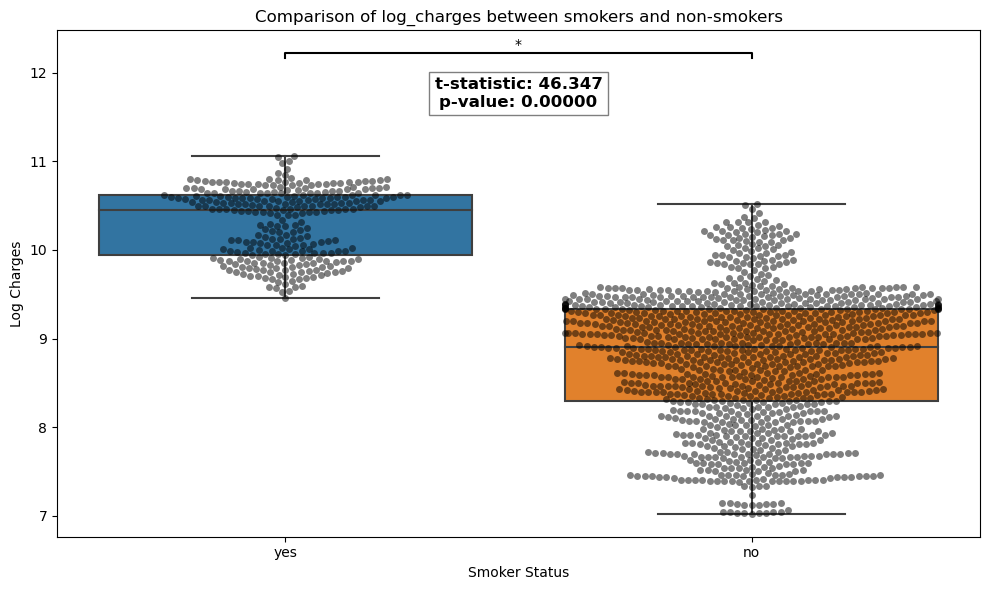

In [9]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='smoker', y='log_charges', data=df)
sns.swarmplot(x='smoker', y='log_charges', data=df, color='black', alpha=0.5)
y_max = df['log_charges'].max()
plt.text(0.5, y_max * 1.05, f't-statistic: {t_stat:.3f}\np-value: {p_value:.5f}', 
         horizontalalignment='center', size=12, weight='bold',
         bbox=dict(facecolor='white', alpha=0.5))
if p_value < 0.05:
    x1, x2 = 0, 1
    y = y_max * 1.1
    plt.plot([x1, x1, x2, x2], [y, y+0.05, y+0.05, y], lw=1.5, c='black')
    plt.text((x1+x2)*.5, y+0.07, '*' if p_value < 0.05 else '**' if p_value < 0.01 else '***', 
             ha='center', va='bottom', color='black')
plt.title('Comparison of log_charges between smokers and non-smokers')
plt.ylabel('Log Charges')
plt.xlabel('Smoker Status')
plt.tight_layout()
plt.show()

In [10]:
anova_model = ols('charges ~ C(region)', data=df).fit()
anova_results = anova_lm(anova_model)
print(anova_results)

               df        sum_sq       mean_sq        F    PR(>F)
C(region)     3.0  1.281906e+09  4.273019e+08  2.92614  0.032763
Residual   1333.0  1.946569e+11  1.460292e+08      NaN       NaN


In [11]:
tukey_result = pairwise_tukeyhsd(endog = df['charges'], groups = df['region'], alpha = 0.05)
print(tukey_result)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------
northeast northwest  -955.5437 0.7457 -3397.7353  1486.648  False
northeast southeast  1329.0269 0.4746 -1045.1237 3703.1776  False
northeast southwest -1059.4471 0.6793 -3499.7595 1380.8652  False
northwest southeast  2284.5706 0.0643     -89.58 4658.7212  False
northwest southwest  -103.9035 0.9995 -2544.2158 2336.4088  False
southeast southwest -2388.4741 0.0477 -4760.6915  -16.2567   True
-----------------------------------------------------------------


Text(0.5, 1.0, 'Boxplot by Region')

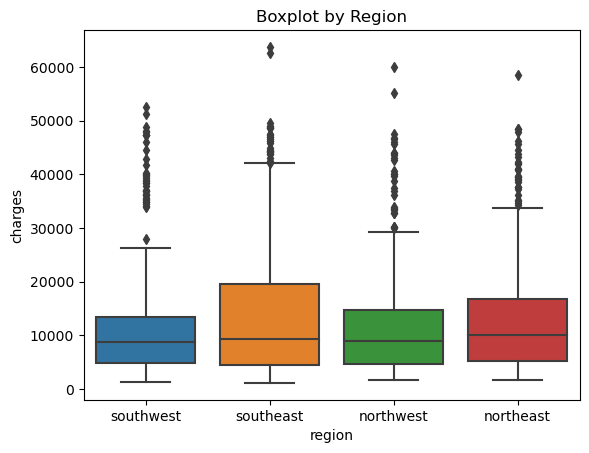

In [12]:
sns.boxplot(data = df, x= "region", y = df['charges'])
plt.title("Boxplot by Region")

In [13]:
ancova_model = ols('charges ~ C(smoker) + bmi + C(smoker) * bmi', data=df).fit()
ancova_results = anova_lm(ancova_model)
print(ancova_results)

                   df        sum_sq       mean_sq            F        PR(>F)
C(smoker)         1.0  1.214307e+11  1.214307e+11  3199.847642  0.000000e+00
bmi               1.0  7.485235e+09  7.485235e+09   197.245054  6.890456e-42
C(smoker):bmi     1.0  1.643697e+10  1.643697e+10   433.134192  1.590920e-83
Residual       1333.0  5.058590e+10  3.794891e+07          NaN           NaN


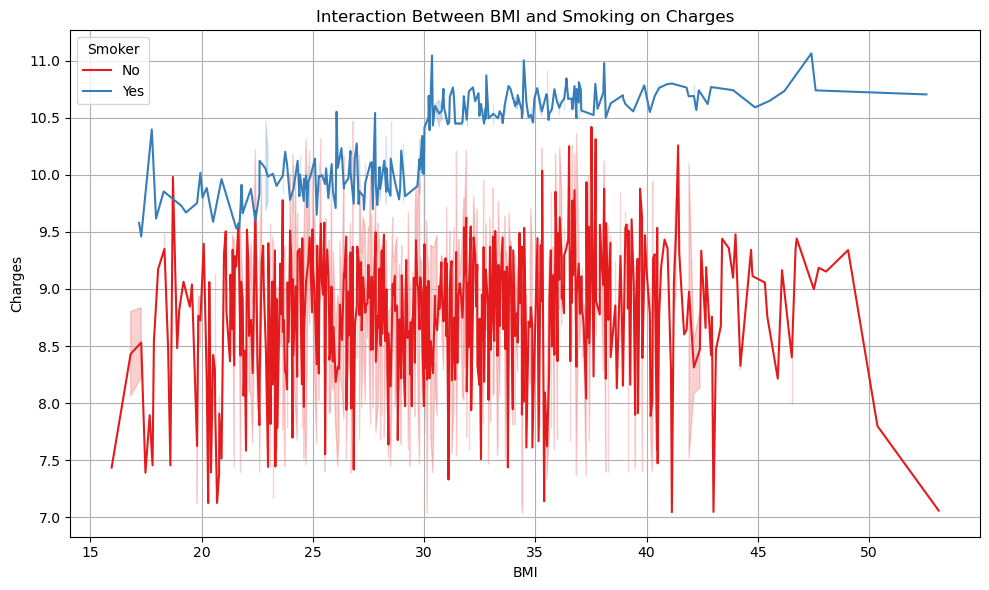

In [14]:
n_non_smokers = len(non_smoker_charges)
n_smokers = len(smoker_charges)
df_plot = pd.DataFrame({
    'BMI': np.concatenate([df.loc[df['smoker'] == 'no', 'bmi'], 
                          df.loc[df['smoker'] == 'yes', 'bmi']]),
    'Charges': np.concatenate([non_smoker_charges, smoker_charges]),
    'Smoker': ['No'] * n_non_smokers + ['Yes'] * n_smokers
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x='BMI', y='Charges', hue='Smoker', palette='Set1')
plt.title('Interaction Between BMI and Smoking on Charges')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.grid(True)
plt.tight_layout()
plt.show()


lr0

In [15]:
dfr = df.copy()
dfr = dfr.drop_duplicates()
dfr = dfr.dropna()

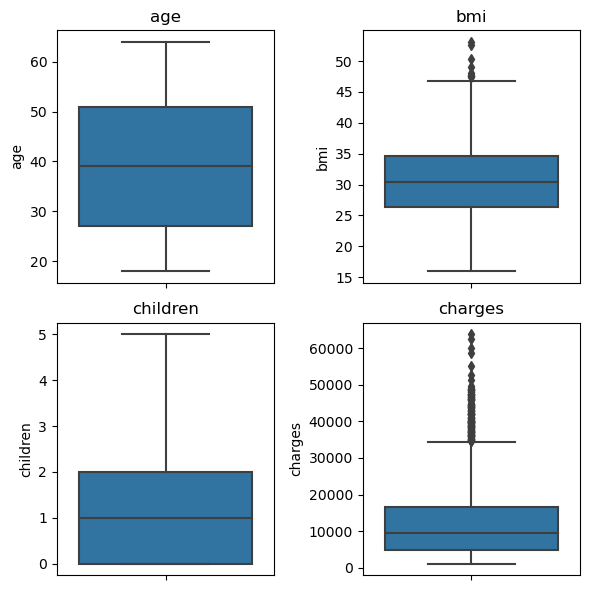

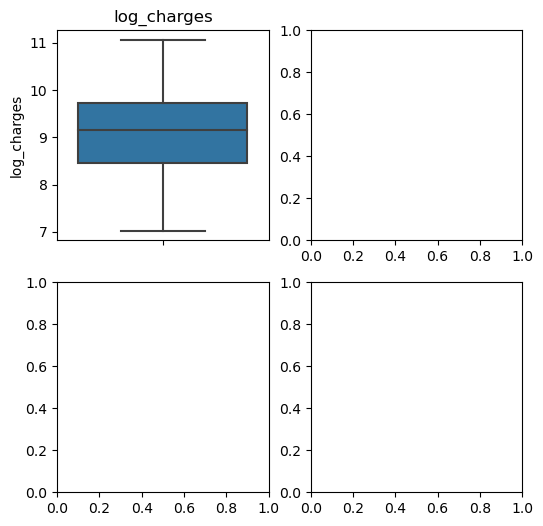

In [16]:
num_columns = df.select_dtypes(include='number').columns 
for ind, column in enumerate(num_columns):
    if ind % 4 == 0:
        fig, axes = plt.subplots(2, 2, figsize=(6, 6))
        axes = axes.flatten()  
    sns.boxplot(data=df, y=column, ax=axes[ind % 4])
    axes[ind % 4].set_title(column)
    if ind % 4 == 3 or ind == len(df.columns) - 1:
        plt.tight_layout()
        plt.show()

/Users/itt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/_f/1gthx_hs1cb8q7jhfs1bj0jr0000gn/T/ipykernel_3077/3748863409.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


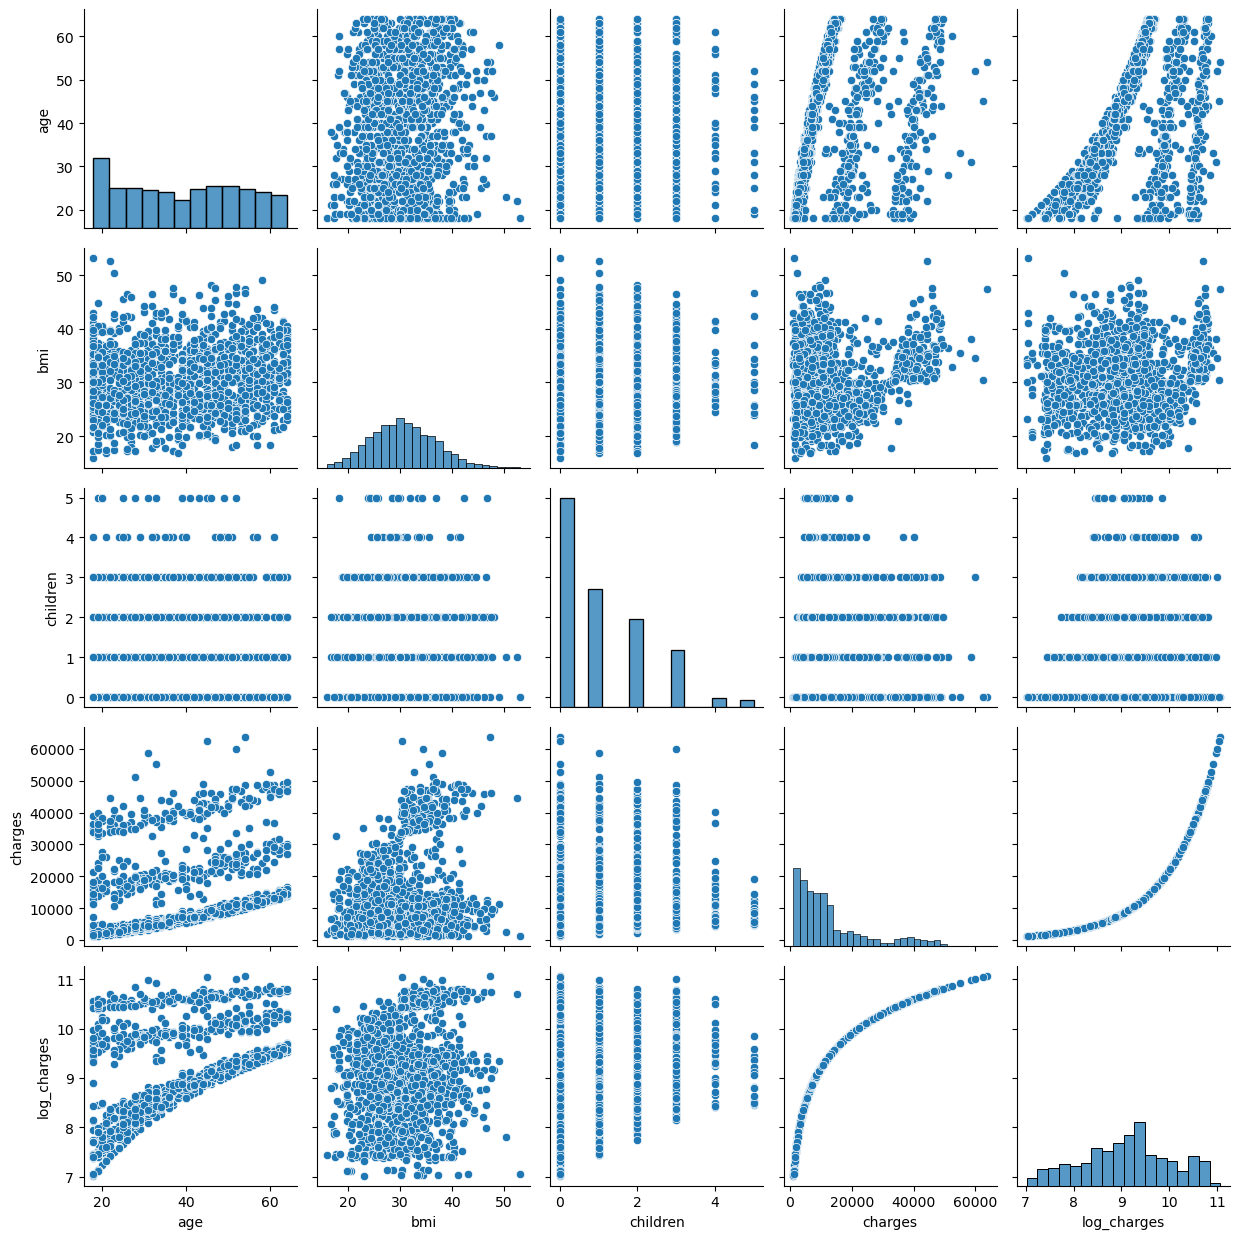

In [17]:
sns.pairplot(data = dfr, height= 2.5)
plt.tight_layout()
plt.show()

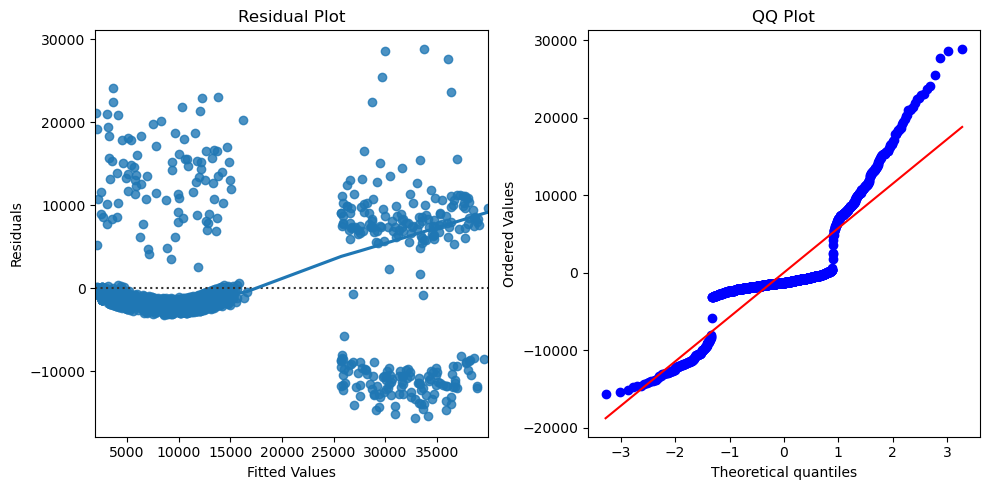

In [18]:
formula = "charges ~ age + sex + children + smoker + C(region)"
OLS = ols(formula = formula, data= dfr)
model = OLS.fit()
def res_qq_plot(model):
    fitted_value = model.fittedvalues
    residuals = model.resid
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.residplot(x=fitted_value, y=residuals, lowess=True, ax=axes[0])
    axes[0].set_xlabel("Fitted Values")
    axes[0].set_ylabel("Residuals")
    axes[0].set_title("Residual Plot")

    stats.probplot(residuals, dist="norm", plot=axes[1])
    axes[1].set_title("QQ Plot")

    plt.tight_layout()
res_qq_plot(model)

lr1

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     602.8
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:23:46   Log-Likelihood:                -827.90
No. Observations:                1337   AIC:                             1672.
Df Residuals:                    1329   BIC:                             1713.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

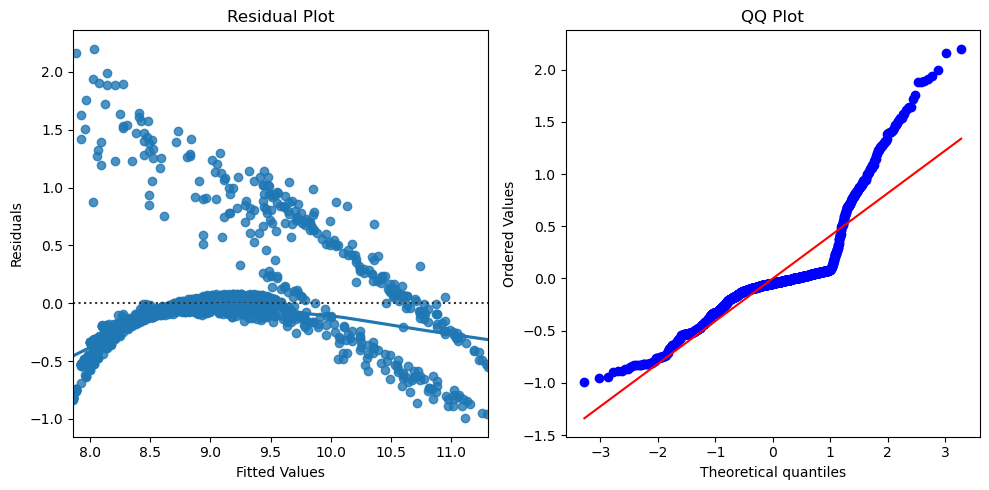

In [19]:
dfr2 = df.copy()
dfr2['charges'] = np.log(dfr2['charges'])
OLS_2 = ols(formula = formula, data= dfr2)
model_2 = OLS_2.fit()
res_qq_plot(model_2)
print(model_2.summary())

It seems like it improved slightly from last model, but there are still some concerns, especially regarding the constant of variance assumption. 

Now, instead of trying different tranformation methods manually, I will use Box Cox which will find the best type of power transfromation (log,square root,etc.) that make 'charges' closly to normal distribution.


$$
y_i^{(\lambda)} = 
\begin{cases} 
\frac{y_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\
\ln(y_i) & \text{if } \lambda = 0,
\end{cases}
$$

In [20]:
y_transformed, fitted_lambda = stats.boxcox(dfr['charges'])
print(f"lambda: {fitted_lambda:.4f}")

lambda: 0.0435


The Box-Cox transformation selected an optimal lambda of 0.0435, which is very very close to 0. However, since I have already tried using a log transformation with numpy, I will not simplify lambda to zero. Instead, I will apply the Box-Cox transformation using the actual lambda value, as it provides a more precise normalization for the target variable.

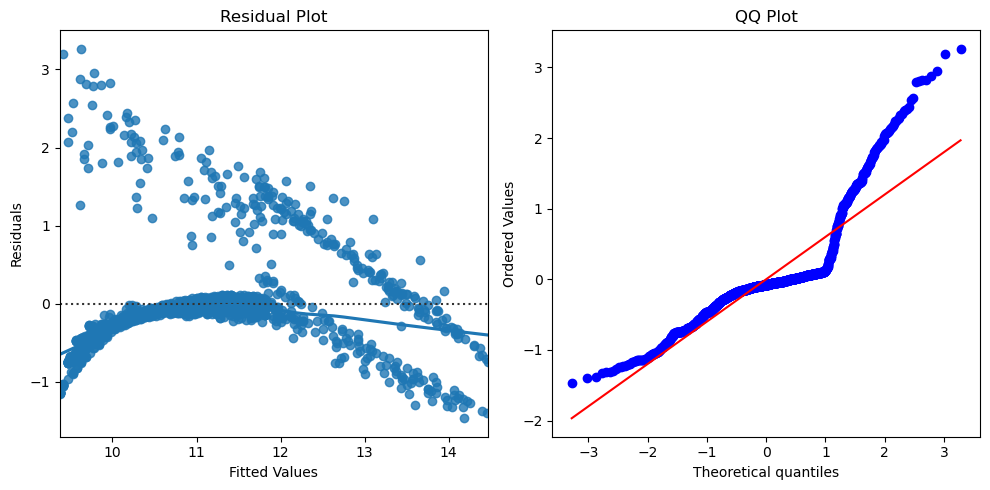

In [21]:
dfr['charges_boxcox'], fitted_lambda = stats.boxcox(dfr['charges'])
formula_3 = "charges_boxcox ~ age + sex + children + smoker + C(region)"
model_3 = ols(formula=formula_3, data=dfr).fit()
res_qq_plot(model_3)

Again, while it is improved slightly, the assumptions still violated.

I will mitigate this by using interactive features.

In [22]:
dfr3 = df.copy()
dfr3 = dfr3.drop_duplicates()
dfr3 = dfr3.dropna()

dfr3['charges_boxcox'], fitted_lambda = stats.boxcox(dfr3['charges'])
X = dfr3[['age', 'bmi', 'children', 'sex', 'smoker', 'region']]
y = dfr3['charges_boxcox']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 42)

In [23]:
categorical_cols = ['sex', 'smoker', 'region']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(PolynomialFeatures(degree=2, include_bias=False)), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

pipeline = make_pipeline(preprocessor, LinearRegression())
pipeline.fit(X_train, y_train)
polynomial_features = pipeline.named_steps['columntransformer'].named_transformers_['num'].named_steps['polynomialfeatures']
feature_names = polynomial_features.get_feature_names_out(numeric_cols)
print("Polynomial Features:", feature_names)
coefficients = pipeline.named_steps['linearregression'].coef_
print("Coefficients:", coefficients)

y_pred = pipeline.predict(X_test)
print(f"R^2 Score: {r2_score(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(((y_pred - y_test) ** 2).mean())}")

Polynomial Features: ['age' 'bmi' 'children' 'age^2' 'age bmi' 'age children' 'bmi^2'
 'bmi children' 'children^2']
Coefficients: [ 6.83609214e-02  9.86677879e-02  4.13113606e-01 -1.33762222e-04
 -1.04395027e-04 -6.87662938e-03 -1.21090630e-03  1.81069503e-03
 -1.76705898e-02 -1.17781624e-01  2.32382619e+00 -7.16227728e-02
 -1.73474541e-01 -1.46574344e-01]
R^2 Score: 0.834971922647911
MAE: 0.39560095285526164
RMSE: 0.5821801136455046


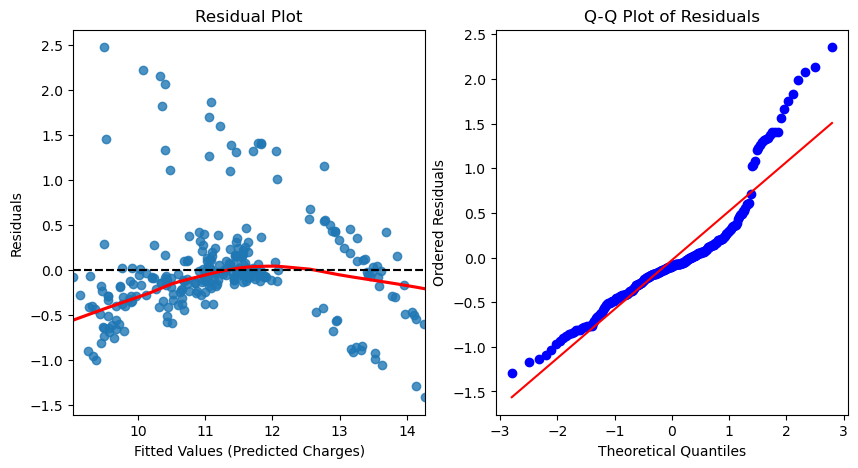

In [24]:
residuals = y_test - y_pred
fig , axes = plt.subplots(1,2,figsize=(10,5))
sns.residplot(x=y_pred, y = residuals, lowess=True, line_kws={'color': 'red'}, ax = axes[0])
axes[0].set_xlabel("Fitted Values (Predicted Charges)")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residual Plot")
axes[0].axhline(0, color='black', linestyle='--')
stats.probplot(residuals, dist="norm", plot = axes[1])
axes[1].set_title("Q-Q Plot of Residuals")
axes[1].set_xlabel("Theoretical Quantiles")
axes[1].set_ylabel("Ordered Residuals")
plt.show()

Logistics

In [25]:
df['charges'].describe()

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

In [26]:
q1,q3 = np.quantile(df['charges'], [0.25,0.75])
iqr = q3-q1
high_cost = q3+(1.5*iqr)
print(high_cost)

34524.777625


In [27]:
higt_cost_proportion = len(df[(df.charges > high_cost)]) / len(df) * 100
print(higt_cost_proportion)

10.396409872849663


In [28]:
dfr = df.copy()
dfr["smoker"] = dfr["smoker"].map({'yes':1, 'no':0})
dfr["sex"] = dfr["sex"].map({'male':1, 'female':0})
scaler = StandardScaler()
dfr[['age', 'bmi']] = scaler.fit_transform(dfr[['age', 'bmi']])

In [29]:
df2 = df.copy()
df2['is_high_charge'] = (df2['charges'] >= high_cost).astype(int)

In [30]:
encoder = OneHotEncoder(drop = 'first', sparse_output=False) 
encoded_data = encoder.fit_transform(df[["region", "sex", "smoker"]])
encoded_df = pd.DataFrame(
    encoded_data,
    columns=encoder.get_feature_names_out(["region", "sex", "smoker"])
)
logis_df = pd.concat([df2.drop(["region", "sex", "smoker"], axis=1), encoded_df], axis=1)

In [31]:
logis_df.isna().sum()
logis_df = logis_df.dropna()

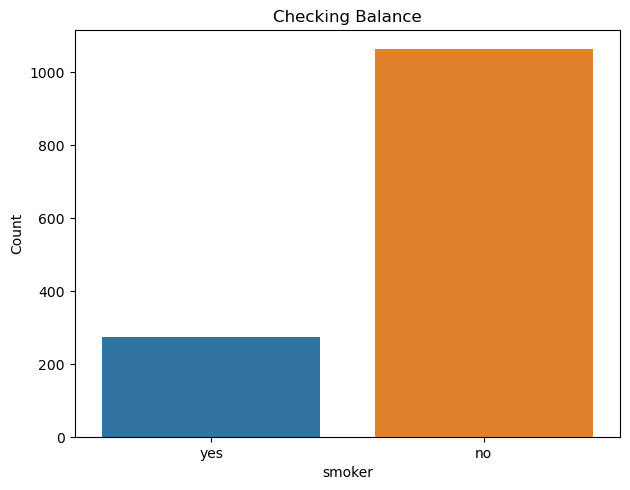

In [32]:
sns.countplot(data=df, x='smoker')
plt.ylabel("Count")
plt.tight_layout()
plt.title("Checking Balance")
plt.show()

In [33]:
X = logis_df[['age', 'bmi', 'children', 'region_northwest',
       'region_southeast', 'region_southwest', 'sex_male', 'smoker_yes']]
y = logis_df['is_high_charge']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 42, stratify= y)

In [34]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced' , max_iter=1000)
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [35]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1] 

In [36]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.7611940298507462
Precision: 0.275
Recall: 0.7857142857142857
F1 Score: 0.40740740740740744


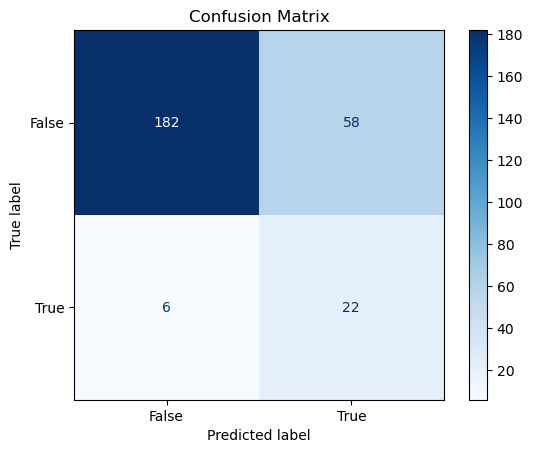

In [37]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

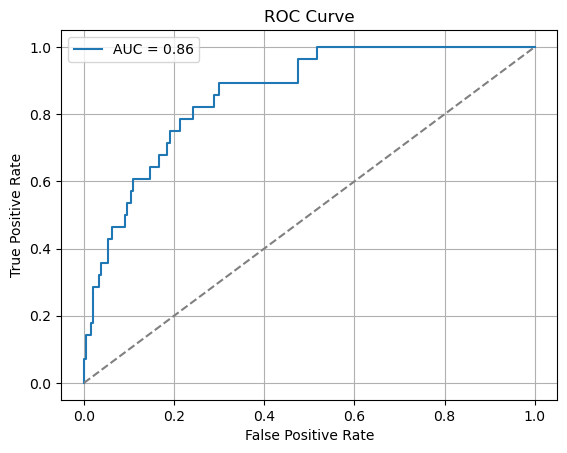

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
feature_names = X_train.columns.tolist()
logistic_model = pipeline.named_steps['logisticregression']
coefficients = logistic_model.coef_[0] 
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df_sorted = coef_df.sort_values('Abs_Coefficient', ascending=False)
print(coef_df_sorted)

            Feature  Coefficient  Abs_Coefficient
1               bmi     1.259405         1.259405
7        smoker_yes     0.830175         0.830175
4  region_southeast    -0.289696         0.289696
6          sex_male     0.208010         0.208010
0               age     0.187789         0.187789
5  region_southwest    -0.154147         0.154147
3  region_northwest     0.125632         0.125632
2          children    -0.064070         0.064070


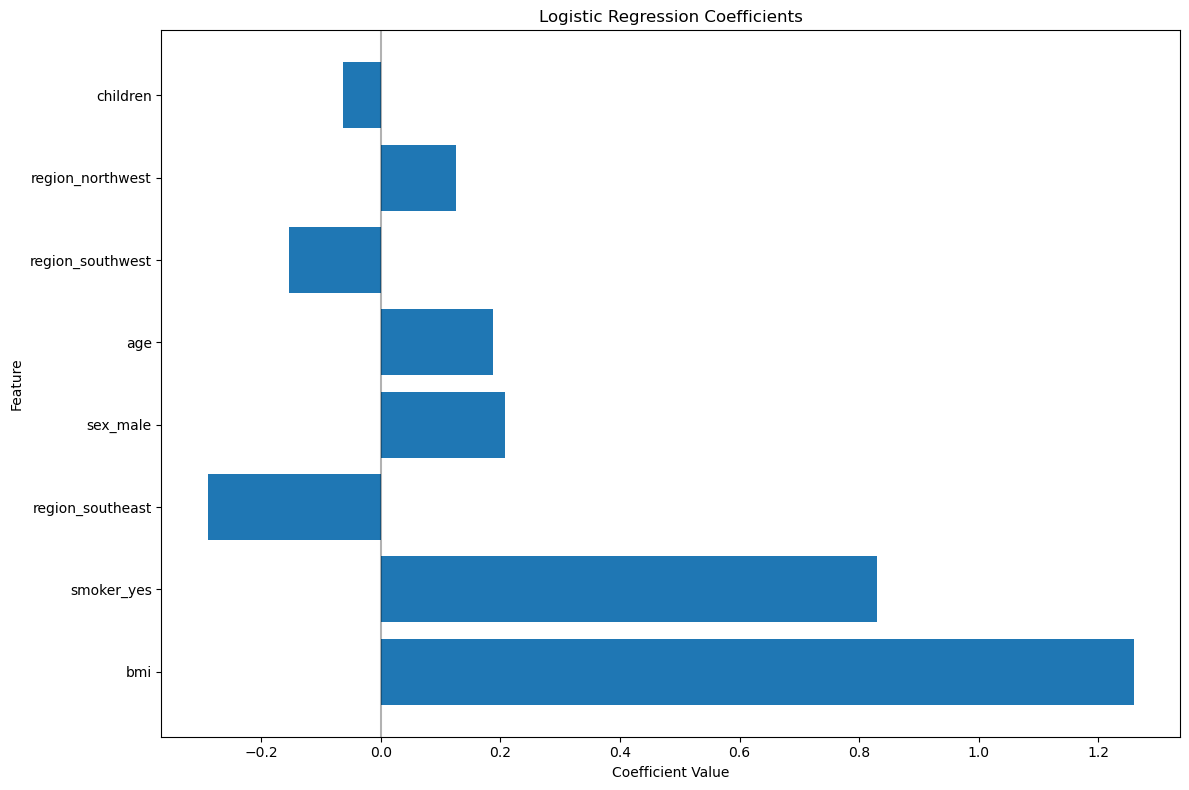

In [40]:
plt.figure(figsize=(12, 8))
plt.barh(coef_df_sorted['Feature'], coef_df_sorted['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
#plt.savefig(r'/Users/itt/Documents/Data Projects/Insurance/image/logis_coor.png', dpi=300)
plt.show()
plt.close() 

In [41]:
df3 = df2.copy()
df3 = df3.drop_duplicates()
df3 = df3.dropna()
df3 = df3.drop(["log_charges", "is_high_charge"], axis=1)
df3.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [42]:
numeric_cols = ['age', 'bmi', 'children', 'charges']  
categorical_cols = ['sex', 'smoker', 'region']

/Users/itt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/itt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/itt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/itt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'au

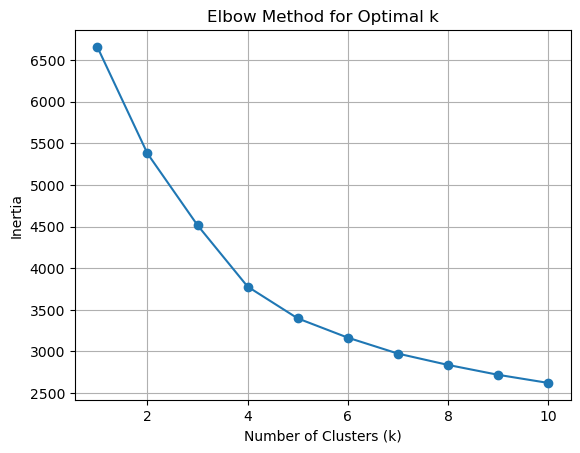

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

inertias = []

for i in range(1, 11):
    kmean_pipe = make_pipeline(preprocessor, KMeans(n_clusters=i, random_state=42))
    kmean_pipe.fit(df3)
    inertia = kmean_pipe.named_steps['kmeans'].inertia_
    inertias.append(inertia)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
#plt.savefig(r'/Users/itt/Documents/Data Projects/Insurance/image/elbow.png', dpi=300)
plt.show()
plt.close() 


/Users/itt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


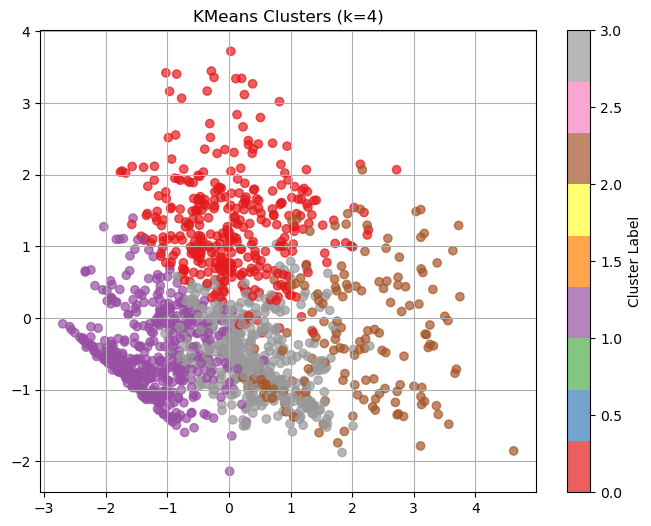

In [44]:
kmeans = make_pipeline(preprocessor, KMeans(n_clusters=4, random_state=42))
kmeans.fit(df3)
X_transformed = preprocessor.fit_transform(df3)
X_pca = PCA(n_components=2).fit_transform(X_transformed)
cluster_labels = kmeans.named_steps['kmeans'].labels_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='Set1', alpha=0.7)
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
plt.title('KMeans Clusters (k=4)')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
#plt.savefig(r'/Users/itt/Documents/Data Projects/Insurance/image/pca.png', dpi=300)
plt.show()
plt.close() 

In [45]:
df3_clustered = df3.copy()
# df3_clustered['cluster'] = kmeans.named_steps['kmeans'].labels_
df3_clustered['cluster'] = cluster_labels
cluster_profile_full = df3_clustered.groupby('cluster').agg({
    'age': 'mean',
    'bmi': 'mean',
    'children': 'mean',
    'charges': 'mean',
    'smoker': lambda x: x.value_counts(normalize=True).to_dict(),  
    'sex': lambda x: x.value_counts(normalize=True).to_dict(),
    'region': lambda x: x.value_counts(normalize=True).to_dict()
}).round(2)

cluster_profile_full.head()

,age,bmi,children,charges,smoker,sex,region
cluster,,,,,,,
0,40.11,30.01,2.69,10969.23,"{'no': 0.8767908309455588, 'yes': 0.1232091690...","{'female': 0.504297994269341, 'male': 0.495702...","{'northwest': 0.2808022922636103, 'southwest':..."
1,25.38,29.18,0.42,5430.90,"{'no': 0.9, 'yes': 0.1}","{'female': 0.5119047619047619, 'male': 0.48809...","{'southeast': 0.28809523809523807, 'northwest'..."
2,39.35,35.33,1.10,41056.03,"{'yes': 0.9548387096774194, 'no': 0.0451612903...","{'male': 0.6451612903225806, 'female': 0.35483...","{'southeast': 0.3870967741935484, 'southwest':..."
3,52.50,30.98,0.43,12787.55,"{'no': 0.9007263922518159, 'yes': 0.0992736077...","{'female': 0.5230024213075061, 'male': 0.47699...","{'northeast': 0.26634382566585957, 'southwest'..."
